# 使用基于组分的特征对神经网络模型进行训练
- 关于e_electronic

- 导入数据

In [1]:
# 导库
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict
from sklearn.linear_model import LinearRegression

In [2]:
# 一些参数
TEST_SIZE = 0.30
RANDOM_STATE = 42

In [3]:
data = pd.read_csv('./data_magpie_training.csv')

In [4]:
data.head()

,material_id,formula_pretty,e_total,e_ionic,e_electronic,composition,MagpieData minimum Number,MagpieData maximum Number,MagpieData range Number,MagpieData mean Number,...,MagpieData range GSmagmom,MagpieData mean GSmagmom,MagpieData avg_dev GSmagmom,MagpieData mode GSmagmom,MagpieData minimum SpaceGroupNumber,MagpieData maximum SpaceGroupNumber,MagpieData range SpaceGroupNumber,MagpieData mean SpaceGroupNumber,MagpieData avg_dev SpaceGroupNumber,MagpieData mode SpaceGroupNumber
0,mp-28967,Ba(PdS2)2,17.048334,7.118969,9.929365,Ba1 Pd2 S4,16.0,56.0,40.0,30.285714,...,0.000000,0.000000,0.000000,0.0,70.0,229.0,159.0,137.000000,76.571429,70.0
1,mp-766094,NbO2F,17.572010,13.469477,4.102533,Nb1 O2 F1,8.0,41.0,33.0,16.500000,...,0.000000,0.000000,0.000000,0.0,12.0,229.0,217.0,67.000000,81.000000,12.0
2,mp-36577,Sr(AsS2)2,18.488667,12.443616,6.045051,Sr1 As2 S4,16.0,38.0,22.0,24.000000,...,0.000000,0.000000,0.000000,0.0,70.0,225.0,155.0,119.571429,56.653061,70.0
3,mp-1102092,NaFe(SO4)2,9.596025,6.499905,3.096120,Na1 Fe1 S2 O8,8.0,26.0,18.0,11.083333,...,2.110663,0.175889,0.322462,0.0,12.0,229.0,217.0,57.833333,61.111111,12.0
4,mp-720391,BH4NF4,6.216546,4.350314,1.866232,B1 H4 N1 F4,1.0,9.0,8.0,5.200000,...,0.000000,0.000000,0.000000,0.0,15.0,194.0,179.0,119.600000,83.680000,15.0


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7277 entries, 0 to 7276
Columns: 138 entries, material_id to MagpieData mode SpaceGroupNumber
dtypes: float64(135), object(3)
memory usage: 7.7+ MB


- 创建X 和 y

In [6]:
X = data.drop(columns=['material_id', 'formula_pretty', 'e_total', 'e_ionic', 'e_electronic', 'composition'])
y = data['e_total']

- 训练集和测试集划分

In [7]:
# 训练集测试集划分
X_train, X_test, y_train, y_test = train_test_split(X.to_numpy(), y.to_numpy(), test_size=TEST_SIZE, random_state=RANDOM_STATE)

- 搭建模型

In [8]:
# 加载数据
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    def __init__(self, data, targets):
        self.data = data
        self.targets = targets.reshape(-1, 1)
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        # 根据索引获取数据和目标，并将它们转换为张量
        x = torch.tensor(self.data[index], dtype=torch.float32)
        y = torch.tensor(self.targets[index], dtype=torch.float32)
        return x, y
    
# 创建自定义数据集实例
dataset = CustomDataset(X_train, y_train)   # 注意X_train,y_train都为pandas.DataFrame
# 创建数据加载器
batch_size = 64
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [9]:
X_train.shape

(5093, 132)

In [10]:
# 搭建神经网络
import torch.nn as nn
# 导入optim
import torch.optim as optim

class NN_model(nn.Module):
    def __init__(self):
        super(NN_model, self).__init__()
        
        # 使用Sequential定义神经网络的结构
        self.layers = nn.Sequential(
            nn.BatchNorm1d(132),
            nn.Linear(132, 66),
            nn.ReLU(),
            nn.Linear(66, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 4),
            nn.ReLU(),
            nn.Linear(4, 1)
        )
        
    def forward(self, x):
        # 前向传播
        return self.layers(x)

- 模型训练

In [17]:
device = torch.device('cpu' if torch.cuda.is_available() else 'cpu')

print(device)
# 定义超参数
input_size = 132
output_size = 1
learning_rate = 0.0001
num_epochs = 3000

# 初始化模型、损失函数和优化器
model = NN_model()
# 使用均方误差作为损失函数
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

model.to(device)
criterion.to(device)
# 训练模型
model.train()
for epoch in range(num_epochs):
    # Forward pass
    epoch_loss = 0
    for i, (features, targets) in enumerate(data_loader):
        features = features.to(device)
        targets = targets.to(device)
        outputs = model(features)
        loss = criterion(outputs, targets)
        epoch_loss += loss.item()
        # Backward and optimize
        optimizer.zero_grad()    # 梯度重置
        loss.backward() # 向后传播计算梯度
        optimizer.step() # 通过梯度更新参数

    if (epoch+1) % 50 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, MSE: {epoch_loss/len(dataset):.4f}')

cpu
Epoch [50/3000], Loss: 98329658.4996, MSE: 19306.8248
Epoch [100/3000], Loss: 60917032.9229, MSE: 11960.9332
Epoch [150/3000], Loss: 60762786.4504, MSE: 11930.6473
Epoch [200/3000], Loss: 60445494.9509, MSE: 11868.3477
Epoch [250/3000], Loss: 59694658.8799, MSE: 11720.9226
Epoch [300/3000], Loss: 58815097.3496, MSE: 11548.2225
Epoch [350/3000], Loss: 57383158.9069, MSE: 11267.0644
Epoch [400/3000], Loss: 55770953.0327, MSE: 10950.5111
Epoch [450/3000], Loss: 52192487.1743, MSE: 10247.8867
Epoch [500/3000], Loss: 47673394.0192, MSE: 9360.5722
Epoch [550/3000], Loss: 46235186.0190, MSE: 9078.1830
Epoch [600/3000], Loss: 32086467.1065, MSE: 6300.1114
Epoch [650/3000], Loss: 29174631.0225, MSE: 5728.3784
Epoch [700/3000], Loss: 19896213.9081, MSE: 3906.5804
Epoch [750/3000], Loss: 14808954.1293, MSE: 2907.7075
Epoch [800/3000], Loss: 9647194.0805, MSE: 1894.2066
Epoch [850/3000], Loss: 6536956.5603, MSE: 1283.5179
Epoch [900/3000], Loss: 6808078.2809, MSE: 1336.7521
Epoch [950/3000], L

In [18]:
X_tensor = torch.tensor(X_train, dtype=torch.float32)
X_tensor = X_tensor.to(device)

tensor([[11.0846],
        [20.6973],
        [37.0346],
        ...,
        [66.2655],
        [12.2881],
        [14.0346]], grad_fn=<AddmmBackward0>)


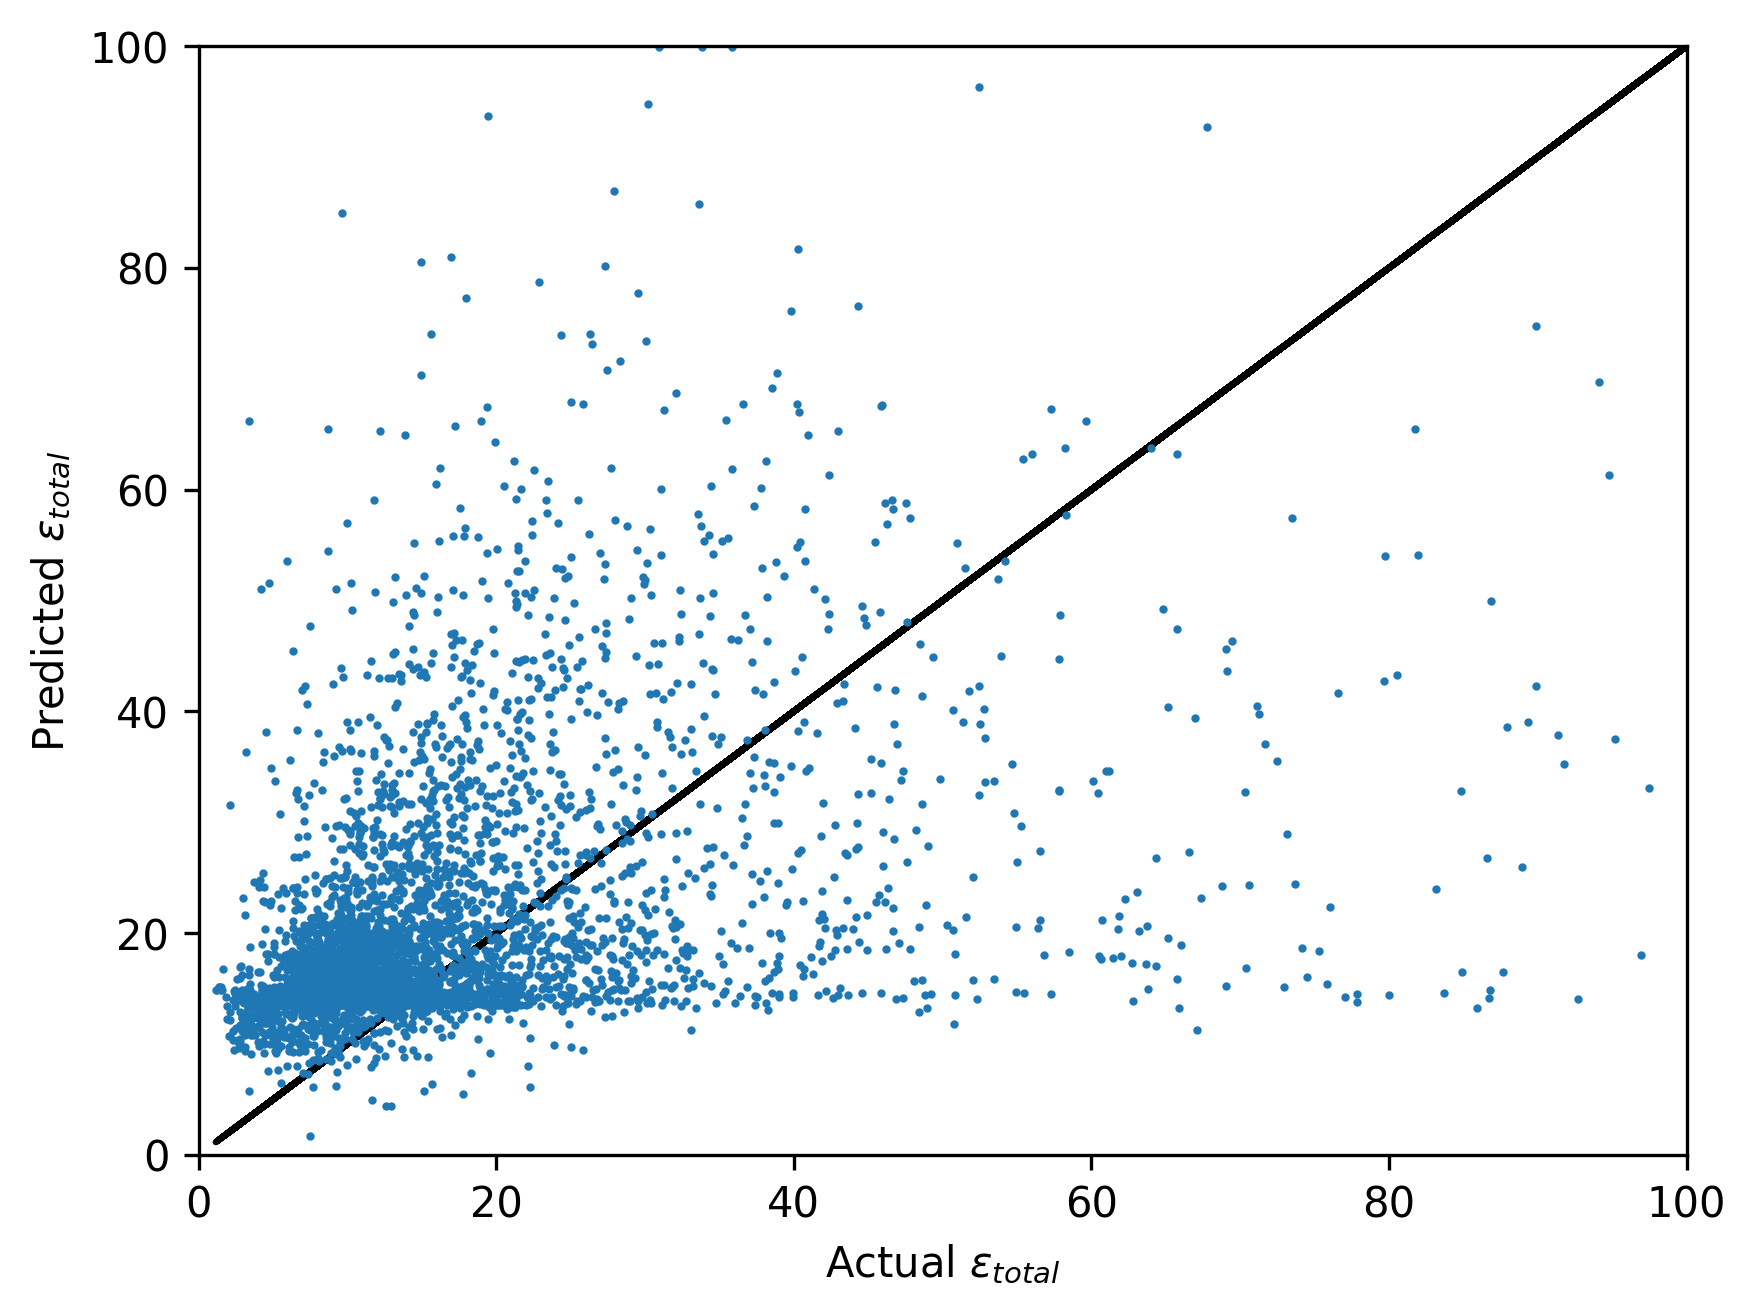

In [19]:
y_hat = model(X_tensor)
print(y_hat)
def parity_plot(y_hat):
    # 绘制parity plot
    fig, ax = plt.subplots(dpi=300)
    ax.scatter(y_train, y_hat, s=1)
    ax.plot(y_train, y_train, c='k', zorder=-5)
    ax.set_xlabel('Actual $\epsilon_{total}$')
    ax.set_ylabel('Predicted $\epsilon_{total}$')
    # ax.set_xscale('log')
    # ax.set_yscale('log')
    ax.set_xlim(0, 100)
    ax.set_ylim(0, 100)
    plt.show()
    
parity_plot(y_hat.detach().cpu().numpy())

In [20]:
# 模型保存
torch.save(model.state_dict(), './NN_model.pth')